<a href="https://colab.research.google.com/github/natryus/LSTM/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from numpy import array
import csv
import pandas

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dropout, Dense, LSTM, Bidirectional, InputLayer, RepeatVector, TimeDistributed, Input
from keras.models import Model


In [2]:
tf.version

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.10/dist-packages/tensorflow/_api/v2/version/__init__.py'>

In [3]:
#-----------------------------------------------------------
# LOAD THE DATASET
#-----------------------------------------------------------

url = 'https://raw.githubusercontent.com/cl4udio/faststorage_trace/main/1.csv'
dataset = pd.read_csv(url,sep=';\t')

#Remove columns 'Timestamp [ms]',
dataset.drop(['Timestamp [ms]',"CPU cores", "CPU capacity provisioned [MHZ]", "CPU usage [%]", "Memory capacity provisioned [KB]"], axis=1, inplace=True)
dataset.drop(['Disk read throughput [KB/s]',"Disk write throughput [KB/s]", "Network received throughput [KB/s]", "Network transmitted throughput [KB/s]"], axis=1, inplace=True)

dataset.plot(subplots=True,figsize=(150, 150))

<ipython-input-3-e5474f80340c>:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dataset = pd.read_csv(url,sep=';\t')


array([<Axes: >, <Axes: >], dtype=object)

In [4]:
print(dataset.shape)

train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]

print(train.shape)
print(test.shape)

train.to_csv("train_1.csv", sep=";",index=False)
test.to_csv("test_1.csv", sep=";",index=False)


(8634, 2)
(6907, 2)
(1727, 2)


In [5]:

scaler = MinMaxScaler(feature_range=(0, 1))
features = scaler.fit_transform(dataset)

print(features.shape)

train_size = int(len(features) * 0.8)
test_size = len(features) - train_size
train, test = features[0:train_size], features[train_size:len(features)]

print(train.shape)
print(test.shape)


(8634, 2)
(6907, 2)
(1727, 2)


In [6]:
#https://www.analyticsvidhya.com/blog/2020/10/multivariate-multi-step-time-series-forecasting-using-stacked-lstm-sequence-to-sequence-autoencoder-in-tensorflow-2-0-keras/

def split_series(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations
  #
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [7]:

n_past = 12
n_future = 6
n_features = 2


batch_size = 128
epochs = 100
hidden_units = 64


In [8]:
X_train, y_train = split_series(train,n_past, n_future)

#X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
#y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))

print(X_train.shape)
print(y_train.shape)

X_test, y_test = split_series(test,n_past, n_future)

#X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
#y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

print(X_test.shape)
print(y_test.shape)

List_columns = ['Lines', 'Window', 'Feature']


#df = pd.DataFrame(X_train).to_csv('X_train_dataframe_1.csv',index=False)

# convert it to stacked format using Pandas
#stacked = pd.Panel(X_train.swapaxes(1,2)).to_frame().stack().reset_index()
#stacked.columns = ['x', 'y', 'z', 'value']
# save to disk
#stacked.to_csv('stacked.csv', index=False)


##########################################

np_array = np.array(X_train)
np_array_col = np.array(List_columns)
with open('X_train.csv', 'w') as csvfile:
    write = csv.writer(csvfile)
    write.writerow(np_array_col)
    write.writerows(np_array)


np_array = np.array(y_train)
np_array_col = np.array(List_columns)
with open('y_train.csv', 'w') as csvfile:
    write = csv.writer(csvfile)
    write.writerow(np_array_col)
    write.writerows(np_array)


np_array = np.array(X_test)
np_array_col = np.array(List_columns)
with open('X_test.csv', 'w') as csvfile:
    write = csv.writer(csvfile)
    write.writerow(np_array_col)
    write.writerows(np_array)


np_array = np.array(y_test)
np_array_col = np.array(List_columns)
with open('y_test.csv', 'w') as csvfile:
    write = csv.writer(csvfile)
    write.writerow(np_array_col)
    write.writerows(np_array)


(6890, 12, 2)
(6890, 6, 2)
(1710, 12, 2)
(1710, 6, 2)


In [9]:
#none batch size

#-----------------------------------------------------------
# USING A MODEL FOR PREDICTION
#-----------------------------------------------------------

keras.backend.clear_session()


model = Sequential()

model.add(InputLayer((n_past, n_features)))
model.add(LSTM(hidden_units,activation='relu'))#, return_sequences=True))
#model.add(Dropout(0.4))

#model.add(LSTM(hidden_units,activation='relu')) #new test
#model.add(Dropout(0.4))

model.add(RepeatVector(n_future))

model.add(LSTM(hidden_units,activation='relu' , return_sequences=True))
#model.add(Dropout(0.4))

#model.add(LSTM(hidden_units,activation='relu' , return_sequences=True)) #new test

model.add(TimeDistributed(Dense(n_features)))


model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17152     
                                                                 
 repeat_vector (RepeatVecto  (None, 6, 64)             0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 6, 64)             33024     
                                                                 
 time_distributed (TimeDist  (None, 6, 2)              130       
 ributed)                                                        
                                                                 
Total params: 50306 (196.51 KB)
Trainable params: 50306 (196.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
from os import name

# Define an input sequence and process it.
encoder_inputs = Input(shape=(n_past, n_features))

# Encoder
encoder = LSTM(hidden_units, return_state=True)
encoder_sequence_output, final_memory_state_h, final_carry_state_c = encoder(encoder_inputs) # Return states in addition to output
encoder_states = [final_memory_state_h, final_carry_state_c] # Discard 'encoder_outputs' and only keep the states

print(encoder_sequence_output.shape)
print(final_memory_state_h.shape)
print(final_carry_state_c.shape)

# Feature vector
decoder_inputs = RepeatVector(n_future)(encoder_sequence_output)

# Decoder
decoder = LSTM(hidden_units, return_sequences=True)(decoder_inputs, initial_state = encoder_states)

decoder_outputs = Dense(n_features)(decoder)
#decoder_outputs = TimeDistributed(Dense(n_features))(decoder)

model_lstm = Model(encoder_inputs,decoder_outputs)

tf.keras.utils.plot_model(model_lstm, to_file='Encoder.png', show_shapes=True)


model_lstm.summary()

(None, 64)
(None, 64)
(None, 64)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 12, 2)]              0         []                            
                                                                                                  
 lstm_2 (LSTM)               [(None, 64),                 17152     ['input_2[0][0]']             
                              (None, 64),                                                         
                              (None, 64)]                                                         
                                                                                                  
 repeat_vector_1 (RepeatVec  (None, 6, 64)                0         ['lstm_2[0][0]']              
 tor)                                                        

In [11]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['RootMeanSquaredError'])
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test,y_test))


Epoch 1/100
54/54 [==============================] - 6s 61ms/step - loss: 0.0077 - root_mean_squared_error: 0.0880 - val_loss: 0.0221 - val_root_mean_squared_error: 0.1485
Epoch 2/100
54/54 [==============================] - 2s 30ms/step - loss: 0.0059 - root_mean_squared_error: 0.0767 - val_loss: 0.0182 - val_root_mean_squared_error: 0.1351
Epoch 3/100
54/54 [==============================] - 1s 27ms/step - loss: 0.0053 - root_mean_squared_error: 0.0727 - val_loss: 0.0164 - val_root_mean_squared_error: 0.1283
Epoch 4/100
54/54 [==============================] - 2s 35ms/step - loss: 0.0051 - root_mean_squared_error: 0.0715 - val_loss: 0.0158 - val_root_mean_squared_error: 0.1259
Epoch 5/100
54/54 [==============================] - 2s 30ms/step - loss: 0.0049 - root_mean_squared_error: 0.0701 - val_loss: 0.0152 - val_root_mean_squared_error: 0.1232
Epoch 6/100
54/54 [==============================] - 1s 27ms/step - loss: 0.0050 - root_mean_squared_error: 0.0708 - val_loss: 0.0154 - val_

In [12]:
model.save("kerasLSTMModel_horizon.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
model.evaluate(X_test,y_test)

54/54 [==============================] - 0s 4ms/step - loss: 0.0149 - root_mean_squared_error: 0.1222


[0.014938493259251118, 0.12222312390804291]

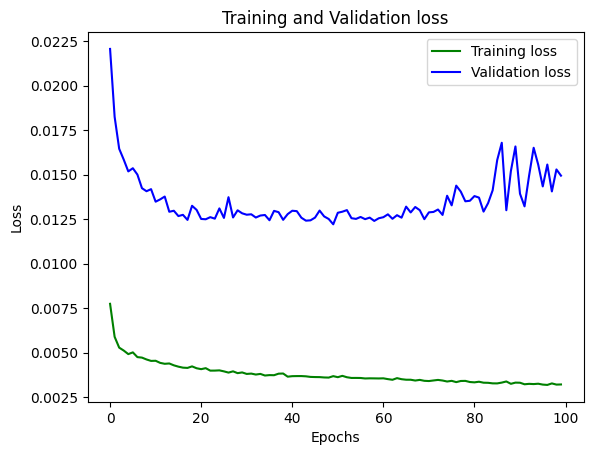

In [14]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'], 'g')
plt.plot(history.history['val_loss'], 'b')
plt.title('Training and Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training loss', 'Validation loss'], loc='upper right')
plt.show()

In [15]:
#-----------------------------------------------------------
# MAKING PREDICTIONS
#-----------------------------------------------------------

testPredict = model.predict(X_test)
print(testPredict.shape)


54/54 [==============================] - 1s 4ms/step
(1710, 6, 2)


<Axes: >

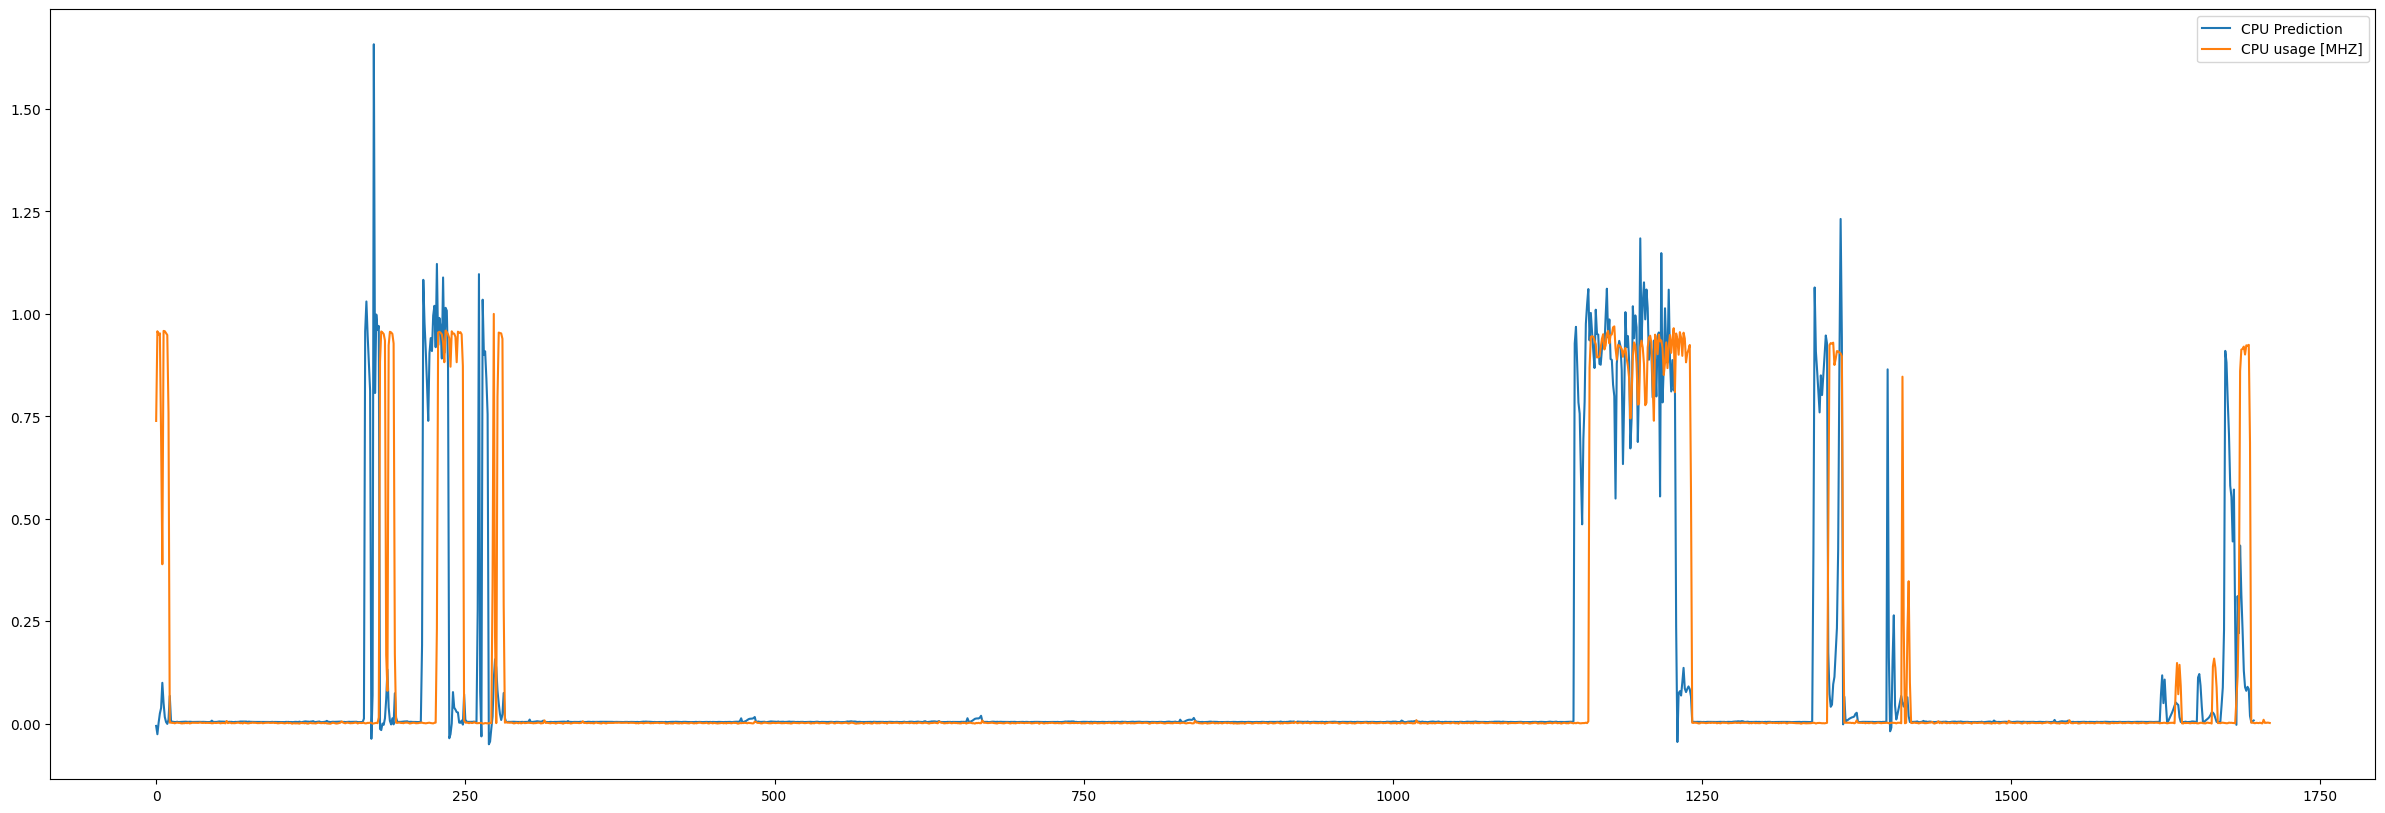

In [16]:
pt1 = pd.DataFrame(testPredict[12+1:, 0, 0], columns = ['CPU Prediction']).plot(figsize=(30, 10))
pd.DataFrame(y_test[:, 0, 0], columns = ['CPU usage [MHZ]']).plot(ax=pt1)
